# Litteraturbanken Author 
version 1.12 

* this [notebook](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
* [T238932 API Litteraturbanken]([https://phabricator.wikimedia.org/T238932)
  * good API documention has not been found
  * GITHUB [spraakbanken/littb-frontend](https://github.com/spraakbanken/littb-frontend)
      Open question how to see [JSON 23](https://github.com/spraakbanken/littb-frontend/issues/23)
  * API [get_authors](https://litteraturbanken.se/api/get_authors)
  * [url_list](https://litteraturbanken.se/api/url_list)
  * [API List all 0-10 include](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10&include=authors,forfattare,lbworkid,titlepath,title,librisid,mediatype,main_author.author_id)
    * [List all 0-10](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10)
  * Wikidata 
    * property [P5101](https://www.wikidata.org/wiki/Property:P5101)
    * [other properties](https://w.wiki/eck) on the same object as Litterturbanken Author

**The objective** Find all Litteraturbanken Author objects that has Show True and have a WIkidata oibject for that item

**Lesson learned**
1. we need to filter in Show True
  1-1. looks like we need better filter e.g. "[CanthM](https://litteraturbanken.se/f%C3%B6rfattare/CanthM)" has false but has text 
2. in Wikidata we get entries from my earlier load but also Mix-and-Match [katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) --> we have also got the form "authorid_norm" that I feel we should not use --> some cleaning
3. we have a big number of Authors not matched to Wikidata abr 790 authors that we should try to match or create new records in Wikidata


## Issues
### 1) Filter out authors with no books 
* BergenstråhleJ miss books 
* BjorklundJA miss books

**solution** Filter on field Show

LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True]  
### 2) copyright on metadata?
We need CC0 to import data in Wikidata (see [Wikidata:Licensing](https://www.wikidata.org/wiki/Wikidata:Licensing)) e.g. if we should add all books as objects in Wikidata with no text and create links to Litteraturbanken then fields like below need to be [CC-0](https://creativecommons.org/share-your-work/public-domain/cc0/)  
* Författare
* Verk
* Libris-id 
* förlaga	
* eid	
* Införd	
* Länk i klartext	
* Epub	
* Källa

In [1]:
import ipyplot
listOfImageNames = ['LitteraturbankenWD.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

In [2]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2020-10-05 11:48:37.806786


In [3]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None) 
 
url = "https://litteraturbanken.se/api/get_authors"
r = http.request('GET', url)
data = json.loads(r.data)
df = pd.DataFrame(data["data"])

In [4]:
df.head()

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
0,AarneA,AarneA,"{'date': '1867', 'plain': '1867'}",d4646f71d18e1304e4b16a557dd2f8cf,1600563813743,"{'date': '1925', 'plain': '1925'}",author,Antti Aarne,male,2014-02-11,None,0xbfm5hj2hjvvwn,"Aarne, Antti",None,False,False,Aarne,2019-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AasenE,AasenE,"{'date': '1935', 'plain': '1935'}",f9d8d6666830bbe11a5153518eb5ca7b,1600563813501,NaN,author,Elisabeth Aasen,female,2014-03-13,None,53hlsf1p1mc2mpw,"Aasen, Elisabeth",None,False,True,Aasen,2019-10-16,"{'birthplace': None, 'birthplace_label': None,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AbeniusM,AbeniusM,"{'date': '1899', 'plain': '1899'}",3f54cad107a4eabdbe746046f109a593,1600563813504,{'plain': '1970'},author,Margit Abenius,female,2017-04-14,\n<p>MARGIT ABENIUS (1899–1970): ”Margit Abeni...,ljx00mt45v0dfx5,"Abenius, Margit",None,True,True,Abenius,2019-10-16,"{'birthplace': [14.628893758, 61.090146823], '...",1.600608e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AbrahamssonG,AbrahamssonG,"{'date': '1961', 'plain': '1961'}",3d398cb6d33ac0cb9f1f0bc26d6eb9bf,1600563813515,NaN,author,Gunnel Abrahamsson,female,2014-02-11,None,NaN,"Abrahamsson, Gunnel",None,False,False,Abrahamsson,2014-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AbrahamssonS,AbrahamssonS,"{'date': '1872', 'plain': '1872'}",4f3cceeb16912e0524fd79011dafbf7f,1600563813518,"{'date': '1911', 'plain': '1911'}",author,Selma Abrahamsson,female,2018-10-25,None,NaN,"Abrahamsson, Selma",None,False,True,Abrahamsson,2018-10-25,NaN,1.600608e+12,{'intro': ' <p>SELMA ABRAHAMSSON (1872–1911) ...,722.0,"[{'authorid': 'Flavia_pseudonym', 'authorid_no...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#df.info() 
df[df['authorid'].str.contains("HallbergP")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
1267,HallbergP,HallbergP,"{'date': '1953', 'plain': '1953'}",d1d8f10cfadf22000a08fedf63f9cc1a,1600563814722,NaN,author,Peter Hallberg,male,2014-02-11,None,NaN,"Hallberg, Peter",None,True,False,Hallberg,2014-03-07,NaN,1.600608e+12,NaN,3107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1268,HallbergPeter,HallbergPeter,"{'date': '1916', 'plain': '1916'}",cc158d392499726eaf642eb66a947a9b,1600563817288,"{'date': '1995', 'plain': '1995'}",author,Peter Hallberg,male,2020-02-11,None,zw9cd0mh188dcx7,"Hallberg, Peter",None,True,True,Hallberg,2020-02-11,NaN,1.600608e+12,NaN,1101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
listLittWD = []
for index,row in df.iterrows():
    new_item = dict()
    new_item['authorid'] = row['authorid']
    new_item['authorid_norm'] = row['authorid_norm']
    new_item['show'] = row['show']
    new_item['updated'] = row['updated']
    new_item['imported'] = row['imported']
    new_item['librisid'] = row['librisid']   
    wd = row['wikidata']
    try:            
        new_item['wd_hos_Litteraturbanken'] = wd['wikidata_id']
    except:
        pass
    listLittWD.append(new_item)
LitteraturbankenTot = pd.DataFrame(listLittWD,
                  columns=['authorid','wd_hos_Litteraturbanken','authorid_norm','show','updated','imported','librisid'])
LitteraturbankenTot["updated"] = LitteraturbankenTot["updated"].astype("datetime64")
LitteraturbankenTot["imported"] = LitteraturbankenTot["imported"].astype("datetime64")

LitteraturbankenTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 3656 non-null   object        
 1   wd_hos_Litteraturbanken  1418 non-null   object        
 2   authorid_norm            3656 non-null   object        
 3   show                     3656 non-null   bool          
 4   updated                  2989 non-null   datetime64[ns]
 5   imported                 2989 non-null   datetime64[ns]
 6   librisid                 1929 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 175.1+ KB


In [40]:
#LitteraturbankenTot["authorid"].value_counts()

In [8]:
LitteraturbankenTot["show"].value_counts()

True     2288
False    1368
Name: show, dtype: int64

In [9]:
LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True] 

LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 1 to 3655
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 2288 non-null   object        
 1   wd_hos_Litteraturbanken  1318 non-null   object        
 2   authorid_norm            2288 non-null   object        
 3   show                     2288 non-null   bool          
 4   updated                  1837 non-null   datetime64[ns]
 5   imported                 1837 non-null   datetime64[ns]
 6   librisid                 1212 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 127.4+ KB


In [10]:
LitteraturbankenTotShow

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
1,AasenE,Q11967131,AasenE,True,2019-10-16,2014-03-13,53hlsf1p1mc2mpw
2,AbeniusM,Q4933592,AbeniusM,True,2019-10-16,2017-04-14,ljx00mt45v0dfx5
4,AbrahamssonS,NaN,AbrahamssonS,True,2018-10-25,2018-10-25,NaN
5,AchariusE,Q365923,AchariusE,True,2019-10-16,2018-02-01,dbqtx0hx5srsg85
6,AckeJAG,NaN,AckeJAG,True,2020-09-21,2020-09-21,tr577tpc0k0tfc9
...,...,...,...,...,...,...,...
3644,ÖhmanA,Q6256668,OhmanA,True,NaT,NaT,NaN
3645,OhmanFA,NaN,OhmanFA,True,NaT,NaT,NaN
3647,ÖnnerforsA,NaN,OnnerforsA,True,2020-05-26,2020-05-25,qn246nn82v714bj
3653,ÖstinO,NaN,OstinO,True,NaT,NaT,NaN


In [11]:
# latest updated 
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['updated'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:20]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Eugénie,NaN,Eugenie,True,2022-02-22,2022-02-22,vs6888xd2lx9tfd
1,WägnerE,Q270468,WagnerE,True,2020-09-22,2010-02-17,0xbdgmxj0thr95n
2,JörlinE,NaN,JorlinE,True,2020-09-21,2020-09-21,NaN
3,FechtPM,NaN,FechtPM,True,2020-09-21,2020-09-21,NaN
4,RichardsonJ,NaN,RichardsonJ,True,2020-09-21,2020-09-21,NaN
5,BrattI,NaN,BrattI,True,2020-09-21,2020-09-21,hftwzbq12j7vcjz
6,FrondinE,NaN,FrondinE,True,2020-09-21,2020-09-21,zw9dkwmh3fc7gdr
7,LaurentiusPetriGothus,NaN,LaurentiusPetriGothus,True,2020-09-21,2020-09-21,64jlpf6q2k76524
8,BerglundD,NaN,BerglundD,True,2020-09-21,2020-09-21,NaN
9,HallmanJG,NaN,HallmanJG,True,2020-09-21,2020-09-21,nl024sx63m6jpz4


In [12]:
# latest imported 
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['imported'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:20]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Eugénie,NaN,Eugenie,True,2022-02-22,2022-02-22,vs6888xd2lx9tfd
1,HallmanJG,NaN,HallmanJG,True,2020-09-21,2020-09-21,nl024sx63m6jpz4
2,JohanIII,NaN,JohanIII,True,2020-09-21,2020-09-21,ljx016344bl6mdn
3,WestdahlP,NaN,WestdahlP,True,2020-09-21,2020-09-21,NaN
4,WahlenbergG,NaN,WahlenbergG,True,2020-09-21,2020-09-21,dbqspmqx0z27d0d
5,AckeJAG,NaN,AckeJAG,True,2020-09-21,2020-09-21,tr577tpc0k0tfc9
6,HolthusenCJ,NaN,HolthusenCJ,True,2020-09-21,2020-09-21,NaN
7,TollinF,NaN,TollinF,True,2020-09-21,2020-09-21,53hkn33p1btlh7l
8,BäckströmPO,NaN,BackstromPO,True,2020-09-21,2020-09-21,53hlqskp2qx9r38
9,DahlgrenL,NaN,DahlgrenL,True,2020-09-21,2020-09-21,42gjklkn56sfzxw


In [13]:
df[df['authorid'].str.contains("AbeniusM")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
2,AbeniusM,AbeniusM,"{'date': '1899', 'plain': '1899'}",3f54cad107a4eabdbe746046f109a593,1600563813504,{'plain': '1970'},author,Margit Abenius,female,2017-04-14,\n<p>MARGIT ABENIUS (1899–1970): ”Margit Abeni...,ljx00mt45v0dfx5,"Abenius, Margit",None,True,True,Abenius,2019-10-16,"{'birthplace': [14.628893758, 61.090146823], '...",1.600608e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Wikidata

In [14]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?authorid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P5101 ?authorid
} order by ?authorid"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittbanktot = get_sparql_dataframe(endpoint_url, query)


In [15]:
WDLittbanktot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  1665 non-null   object
 1   authorid    1665 non-null   object
dtypes: object(2)
memory usage: 26.1+ KB


Duplicates in WD https://w.wiki/eM2
We try to have one if two then set one to preferred rang

In [16]:
WDLittbanktot[WDLittbanktot.duplicated(subset=['WikidataID'])].count()

WikidataID    0
authorid      0
dtype: int64

### Check diff Wikidata <-> Litteraturbanken 

1. **WD_only** --> är oftast att Wikidata har den normerade egenskapen och skall bytas
2. **Litterturbanken_only** skall skapas/matchas i Wikidata
 

In [17]:
dfmerge = pd.merge(WDLittbanktot, LitteraturbankenTotShow,how='outer', on='authorid',indicator=True)

In [18]:
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
dfmerge["_merge"].value_counts()  

both          1649
right_only     640
left_only       16
Name: _merge, dtype: int64

In [19]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','Litterturbanken_only')
dfmerge.rename(columns={"_merge": "WD_Litteraturbanken"},inplace = True)
  
#    
dfmerge[0:10]  

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
0,Q11967131,AasenE,Q11967131,AasenE,True,2019-10-16,2014-03-13,53hlsf1p1mc2mpw,both
1,Q4933592,AbeniusM,Q4933592,AbeniusM,True,2019-10-16,2017-04-14,ljx00mt45v0dfx5,both
2,Q4934135,AbrahamssonS,NaN,AbrahamssonS,True,2018-10-25,2018-10-25,NaN,both
3,Q365923,AchariusE,Q365923,AchariusE,True,2019-10-16,2018-02-01,dbqtx0hx5srsg85,both
4,Q5541979,AckeJAG,NaN,AckeJAG,True,2020-09-21,2020-09-21,tr577tpc0k0tfc9,both
5,Q109244,AdamBremen,Q109244,AdamBremen,True,2019-10-16,2014-02-05,53hkk5vp1k798w1,both
6,Q4933819,AdelborgO,Q4933819,AdelborgO,True,2019-10-16,2008-11-11,sq466t3b4s743md,both
7,Q3338577,AdlerbethGJ,Q3338577,AdlerbethGJ,True,2019-10-16,2010-10-19,wt794lsf0mx0xqp,both
8,Q918652,AdlersparreG,Q918652,AdlersparreG,True,2019-10-16,2015-02-16,86lnqg0s0b2bxhx,both
9,Q4346827,AdlersparreS,Q4346827,AdlersparreS,True,2019-10-16,2014-02-11,64jlfw3q2m71jcx,both


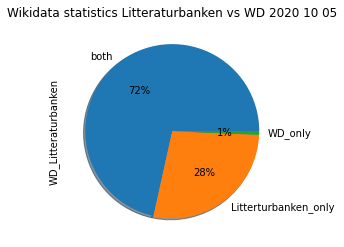

In [20]:
%matplotlib inline 
import matplotlib.pyplot as plt   
mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [21]:
mergeCheckNumber

both                    1649
Litterturbanken_only     640
WD_only                   16
Name: WD_Litteraturbanken, dtype: int64

In [22]:
pd.set_option("display.max.rows", None) 
 
wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"]
# could be items with Show false at Litteraturbanken 
wdonly

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
101,Q2063496,AstromP,NaN,NaN,NaN,NaT,NaT,NaN,WD_only
109,Q99770777,AxenAE,NaN,NaN,NaN,NaT,NaT,NaN,WD_only
186,Q68117,BirchPfeifferC,NaN,NaN,NaN,NaT,NaT,NaN,WD_only
188,Q99770542,BirgisdottirSA,NaN,NaN,NaN,NaT,NaT,NaN,WD_only
191,Q99770648,BjartmarsdottirG,NaN,NaN,NaN,NaT,NaT,NaN,WD_only
199,Q11859217,BjörkmanE,NaN,NaN,NaN,NaT,NaT,NaN,WD_only
283,Q14932468,ButenschönA,NaN,NaN,NaN,NaT,NaT,NaN,WD_only
367,Q99771903,DahlenT,NaN,NaN,NaN,NaT,NaT,NaN,WD_only
504,Q99871759,FjortoftK,NaN,NaN,NaN,NaT,NaT,NaN,WD_only
516,Q99872638,ForsasScottH,NaN,NaN,NaN,NaT,NaT,NaN,WD_only


In [23]:
df[df['authorid_norm'].str.contains("WahlinK")] 
#df[df['authorid'].str.contains("SjödinS")] 

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
3574,WåhlinK,WahlinK,"{'date': '1861', 'plain': '1861'}",b8df8ca649f60fc148478e511156e51c,1600563816844,"{'date': '1937', 'plain': '1937'}",author,Karl Wåhlin,male,2014-02-11,None,vs689v6d41dplmt,"Wåhlin, Karl",None,False,False,Wåhlin,2019-10-16,"{'birthplace': [13.199164196, 55.708313018], '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3575,WåhlinKr,WahlinKr,"{'date': '1942', 'plain': '1942'}",97c8081e467fdac69211feee0e73fbe5,1600563816853,"{'date': '1995', 'plain': '1995'}",author,Kristian Wåhlin,male,NaN,None,NaN,"Wåhlin, Kristian",None,False,False,Wåhlin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df[df['authorid_norm'].str.contains("RomanusAlfvenAC")] 

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
2716,RomanusAlfvénAC,RomanusAlfvenAC,"{'date': '1874', 'plain': '1874'}",111c2a2d1dc80ca70c25df609873b759,1600563816138,"{'date': '1947', 'plain': '1947'}",author,Anna-Clara Romanus-Alfvén,female,NaN,None,NaN,"Romanus-Alfvén, Anna-Clara",None,False,False,Romanus-Alfvén,NaN,"{'birthplace': None, 'birthplace_label': None,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. merge wdonly authorid on authorid_norm --> we get the authorid that we should use 
1. next step is create Quickstatement  for delete and upload the new one see example [Calc](https://docs.google.com/spreadsheets/d/1lw1wqTmFndxlltJHhyEyzQxoGTph6J2tdVCwgmJFHdI/edit?usp=sharing)


In [25]:
wdonlymerge = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid',right_on='authorid_norm')
wdonlymerge[{'WikidataID','authorid_x','authorid_y','show_y'}] 


,authorid_x,authorid_y,WikidataID,show_y
0,AxenAE,AxénAE,Q99770777,True
1,BirgisdottirSA,BirgisdóttirSA,Q99770542,True
2,BjartmarsdottirG,BjartmarsdóttirG,Q99770648,True
3,DahlenT,DahlénT,Q99771903,True
4,FjortoftK,FjørtoftK,Q99871759,True
5,ForsasScottH,ForsåsScottH,Q99872638,True


In [26]:
wddelete = wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="both"]  
wddelete.head()

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
0,Q11967131,AasenE,Q11967131,AasenE,True,2019-10-16,2014-03-13,53hlsf1p1mc2mpw,both
1,Q4933592,AbeniusM,Q4933592,AbeniusM,True,2019-10-16,2017-04-14,ljx00mt45v0dfx5,both
2,Q4934135,AbrahamssonS,NaN,AbrahamssonS,True,2018-10-25,2018-10-25,NaN,both
3,Q365923,AchariusE,Q365923,AchariusE,True,2019-10-16,2018-02-01,dbqtx0hx5srsg85,both
4,Q5541979,AckeJAG,NaN,AckeJAG,True,2020-09-21,2020-09-21,tr577tpc0k0tfc9,both


In [27]:
dfmerge_authorid_norm = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm',indicator=True)

In [28]:
dfmerge_authorid_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348 entries, 0 to 1347
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 1348 non-null   object        
 1   authorid_x                 1348 non-null   object        
 2   wd_hos_Litteraturbanken_x  1075 non-null   object        
 3   authorid_norm_x            1348 non-null   object        
 4   show_x                     1348 non-null   object        
 5   updated_x                  1208 non-null   datetime64[ns]
 6   imported_x                 1208 non-null   datetime64[ns]
 7   librisid_x                 962 non-null    object        
 8   WD_Litteraturbanken        1348 non-null   object        
 9   authorid_y                 1348 non-null   object        
 10  wd_hos_Litteraturbanken_y  1075 non-null   object        
 11  authorid_norm_y            1348 non-null   object        
 12  show_y

In [29]:
dfmerge_authorid_norm.head()

,WikidataID,authorid_x,wd_hos_Litteraturbanken_x,authorid_norm_x,show_x,updated_x,imported_x,librisid_x,WD_Litteraturbanken,authorid_y,wd_hos_Litteraturbanken_y,authorid_norm_y,show_y,updated_y,imported_y,librisid_y,_merge
0,Q11967131,AasenE,Q11967131,AasenE,True,2019-10-16,2014-03-13,53hlsf1p1mc2mpw,both,AasenE,Q11967131,AasenE,True,2019-10-16,2014-03-13,53hlsf1p1mc2mpw,both
1,Q4933592,AbeniusM,Q4933592,AbeniusM,True,2019-10-16,2017-04-14,ljx00mt45v0dfx5,both,AbeniusM,Q4933592,AbeniusM,True,2019-10-16,2017-04-14,ljx00mt45v0dfx5,both
2,Q4934135,AbrahamssonS,NaN,AbrahamssonS,True,2018-10-25,2018-10-25,NaN,both,AbrahamssonS,NaN,AbrahamssonS,True,2018-10-25,2018-10-25,NaN,both
3,Q365923,AchariusE,Q365923,AchariusE,True,2019-10-16,2018-02-01,dbqtx0hx5srsg85,both,AchariusE,Q365923,AchariusE,True,2019-10-16,2018-02-01,dbqtx0hx5srsg85,both
4,Q5541979,AckeJAG,NaN,AckeJAG,True,2020-09-21,2020-09-21,tr577tpc0k0tfc9,both,AckeJAG,NaN,AckeJAG,True,2020-09-21,2020-09-21,tr577tpc0k0tfc9,both


In [30]:
#dfmerge_authorid_norm[{'WikidataID','authorid_x','authorid_y'}] 

### check items not matched to Wikidata 
    use librisid

In [31]:
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    1649
Litterturbanken_only     640
WD_only                   16
Name: WD_Litteraturbanken, dtype: int64

In [32]:
Litterturbanken_only = dfmerge[dfmerge["WD_Litteraturbanken"]=="Litterturbanken_only"]  
Litterturbanken_only.info()
Litterturbanken_only.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 1665 to 2304
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               0 non-null      object        
 1   authorid                 640 non-null    object        
 2   wd_hos_Litteraturbanken  8 non-null      object        
 3   authorid_norm            640 non-null    object        
 4   show                     640 non-null    object        
 5   updated                  358 non-null    datetime64[ns]
 6   imported                 358 non-null    datetime64[ns]
 7   librisid                 33 non-null     object        
 8   WD_Litteraturbanken      640 non-null    object        
dtypes: datetime64[ns](2), object(7)
memory usage: 50.0+ KB


,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
1665,NaN,Eugénie,NaN,Eugenie,True,2022-02-22,2022-02-22,vs6888xd2lx9tfd,Litterturbanken_only
1666,NaN,HolthusenCJ,NaN,HolthusenCJ,True,2020-09-21,2020-09-21,NaN,Litterturbanken_only
1667,NaN,BerglundD,NaN,BerglundD,True,2020-09-21,2020-09-21,NaN,Litterturbanken_only
1668,NaN,LöfgrenE,NaN,LofgrenE,True,2020-08-24,2020-08-24,NaN,Litterturbanken_only
1669,NaN,AtterbomSvensonH,NaN,AtterbomSvensonH,True,2020-08-24,2020-08-24,NaN,Litterturbanken_only
1670,NaN,KnorringO,NaN,KnorringO,True,2020-08-24,2020-08-24,NaN,Litterturbanken_only
1671,NaN,JovikenM,NaN,JovikenM,True,2020-08-17,2020-08-17,NaN,Litterturbanken_only
1672,NaN,MalmrosI,NaN,MalmrosI,True,2020-08-13,2020-08-13,NaN,Litterturbanken_only
1673,NaN,WalleniusGA,NaN,WalleniusGA,True,2020-06-22,2020-06-22,gdsvxdn00rx4nkz,Litterturbanken_only
1674,NaN,BerglindhU,NaN,BerglindhU,True,2020-06-22,2020-06-22,dbqswjtx2csh0hp,Litterturbanken_only


In [33]:
#Get all items with no Wikidata item but has librisid --> can match them using Open Refine 
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()].count()

WikidataID                  0
authorid                   33
wd_hos_Litteraturbanken     2
authorid_norm              33
show                       33
updated                    33
imported                   33
librisid                   33
WD_Litteraturbanken        33
dtype: int64

In [34]:
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()]

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
1665,NaN,Eugénie,NaN,Eugenie,True,2022-02-22,2022-02-22,vs6888xd2lx9tfd,Litterturbanken_only
1673,NaN,WalleniusGA,NaN,WalleniusGA,True,2020-06-22,2020-06-22,gdsvxdn00rx4nkz,Litterturbanken_only
1674,NaN,BerglindhU,NaN,BerglindhU,True,2020-06-22,2020-06-22,dbqswjtx2csh0hp,Litterturbanken_only
1675,NaN,RuheA,NaN,RuheA,True,2020-05-25,2020-05-25,pm1353r73nxlwkf,Litterturbanken_only
1677,NaN,MannheimerO,NaN,MannheimerO,True,2020-05-04,2020-05-04,gdsw4zr01sjm4d8,Litterturbanken_only
1678,NaN,EngeströmL,NaN,EngestromL,True,2020-04-27,2020-04-27,c9prsplw3tz4t23,Litterturbanken_only
1682,NaN,EenbergJ,NaN,EenbergJ,True,2020-03-30,2020-03-30,dbqtz4wx4kwv1w2,Litterturbanken_only
1683,NaN,TornaeusJ,NaN,TornaeusJ,True,2020-02-21,2020-02-21,b8nqtczv51qm272,Litterturbanken_only
1685,NaN,SiwertzS,NaN,SiwertzS,True,2020-02-17,2020-02-17,216411,Litterturbanken_only
1687,NaN,TuderusG,NaN,TuderusG,True,2020-01-22,2020-01-22,khwz2lb33wm7pmq,Litterturbanken_only


### Find objects with Show false at Litteraturbanken 
If found in Wikidata they are candidates to be deleted in Wikidata

In [35]:
LitteraturbankenTotNotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==False]  
dfmergeDelete = pd.merge(WDLittbanktot, LitteraturbankenTotNotShow,how='outer', on='authorid',indicator=True)

In [36]:
# both are candidates to be deleted as they have show False
dfmergeDelete["_merge"].value_counts()  

left_only     1658
right_only    1361
both             7
Name: _merge, dtype: int64

In [37]:
#Coukld be canidate to be deleted in WD not sure
dfmergeDeleteBoth = dfmergeDelete[dfmergeDelete["_merge"]=="both"]  
dfmergeDeleteBoth

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,_merge
186,Q68117,BirchPfeifferC,NaN,BirchPfeifferC,False,2019-05-14,2018-10-25,NaN,both
199,Q11859217,BjörkmanE,NaN,BjorkmanE,False,2018-10-25,2018-10-25,NaN,both
283,Q14932468,ButenschönA,Q14932468,ButenschonA,False,2018-10-25,2018-10-25,NaN,both
781,Q99826706,JohanssonJ,NaN,JohanssonJ,False,2022-02-22,2022-02-22,b8nqthrv2xn31rt,both
1265,Q16946439,RomanusAlfvénAC,Q16946439,RomanusAlfvenAC,False,NaT,NaT,NaN,both
1376,Q3527629,SjödinS,Q3527629,SjodinS,False,2019-10-16,2010-09-28,1zcfhwvk50wff8f,both
1514,Q4458078,TirénG,Q4458078,TirenG,False,2019-10-16,2014-02-11,31fhj5wm4rnx095,both


In [38]:
dfmergeDelete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3026 entries, 0 to 3025
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1665 non-null   object        
 1   authorid                 3026 non-null   object        
 2   wd_hos_Litteraturbanken  100 non-null    object        
 3   authorid_norm            1368 non-null   object        
 4   show                     1368 non-null   object        
 5   updated                  1152 non-null   datetime64[ns]
 6   imported                 1152 non-null   datetime64[ns]
 7   librisid                 717 non-null    object        
 8   _merge                   3026 non-null   category      
dtypes: category(1), datetime64[ns](2), object(6)
memory usage: 215.8+ KB


In [39]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Ended:  2020-10-05 11:48:43.715904
Time elapsed (hh:mm:ss.ms) 0:00:05.909245
